# Adult income - analysis & classification 

The data comes from The [Census Income Data Set](http://archive.ics.uci.edu/ml/datasets/adult) from the UCI Machine Learning Repository. Is also known as Adult income or adult dataset.

**The purpose of classification is to predict, whether an income exceeds 50k per year.**

### Let\`s import this and that

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scikitplot as skplt

#models
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2019)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

### Data import

In [2]:
%time train = pd.read_hdf('../input/train.adult.h5')

CPU times: user 85.4 ms, sys: 21.8 ms, total: 107 ms
Wall time: 307 ms


You can also find the full dataset here:

### A first glance at the dataset

In [3]:
train.sample(5)

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
18912,24,NaN,412156,HS-grad,9,Married-civ-spouse,NaN,Wife,White,False,0,0,40,Mexico,<=50K
1372,43,Private,221550,Masters,14,Never-married,Other-service,Not-in-family,White,False,0,0,30,Poland,<=50K
19761,29,Private,114801,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,40,United-States,<=50K
16661,26,Private,166666,Some-college,10,Never-married,Other-service,Not-in-family,White,False,0,0,35,United-States,<=50K
19680,28,Private,64307,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,True,0,0,40,United-States,<=50K


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           31978 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


There are some missing values and not boolean/integeer columns in the dataset. We'll deal with it.

### Check and fill in missing values

Check missing

In [5]:
train.isna().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education-Num        0
Martial Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours per week       0
Country            583
Target               0
dtype: int64

The simplest way to remove missing values (without removing entire rows) is to fill in it with an unique value.

In [6]:
#You can check, if (-1) is in the dataset by uncommenting below:
#(-1 or '-1' )in train.values 

train = train.fillna(-1)

Check missing 2

In [7]:
train.isna().sum() 

Age               0
Workclass         0
fnlwgt            0
Education         0
Education-Num     0
Martial Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours per week    0
Country           0
Target            0
dtype: int64

### Checking the not numeric values

In [8]:
train.select_dtypes(['object','bool']).apply(lambda x: x.value_counts()).T.stack()

Workclass       Local-gov                      2093.0
                Private                       22696.0
                Self-emp-not-inc               2541.0
                -1                             1836.0
                State-gov                      1298.0
                Self-emp-inc                   1116.0
                Federal-gov                     960.0
                Without-pay                      14.0
                Never-worked                      7.0
Education       HS-grad                       10501.0
                Some-college                   7291.0
                Bachelors                      5355.0
                Masters                        1723.0
                Assoc-voc                      1382.0
                11th                           1175.0
                Assoc-acdm                     1067.0
                10th                            933.0
                7th-8th                         646.0
                Prof-school 

* The "country" column is unbalanced. The US population in the dataset is a despised majority, and the inhabitants of other countries have too little representation to draw conclusions from it. Therefore, I decided to divide the "country" into only two parts: US and non-us.
* "Workclass" Never-worked  &  Without-pay seem to be such a great opportunity to exclude a group of people from  earning-over-50k-category, but their quantitative representation is too small (21 people in total) to become meaningfull :(.
* Race (quantity dominant: white race) and worclass (privat sector) - are also probably to much unbalanced, but intuition can tell us that there is still possibility of finding something interesting in workclass - we should not eliminate  anything hastily.

### Categorizing non-numeric columns

In [9]:
cat_feats = train.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    train['{0}_cat'.format(cat_feat)] = pd.factorize(train[cat_feat])[0]
    
#train.info()
#train.sample(5)

### Finally, we can check correlations :)

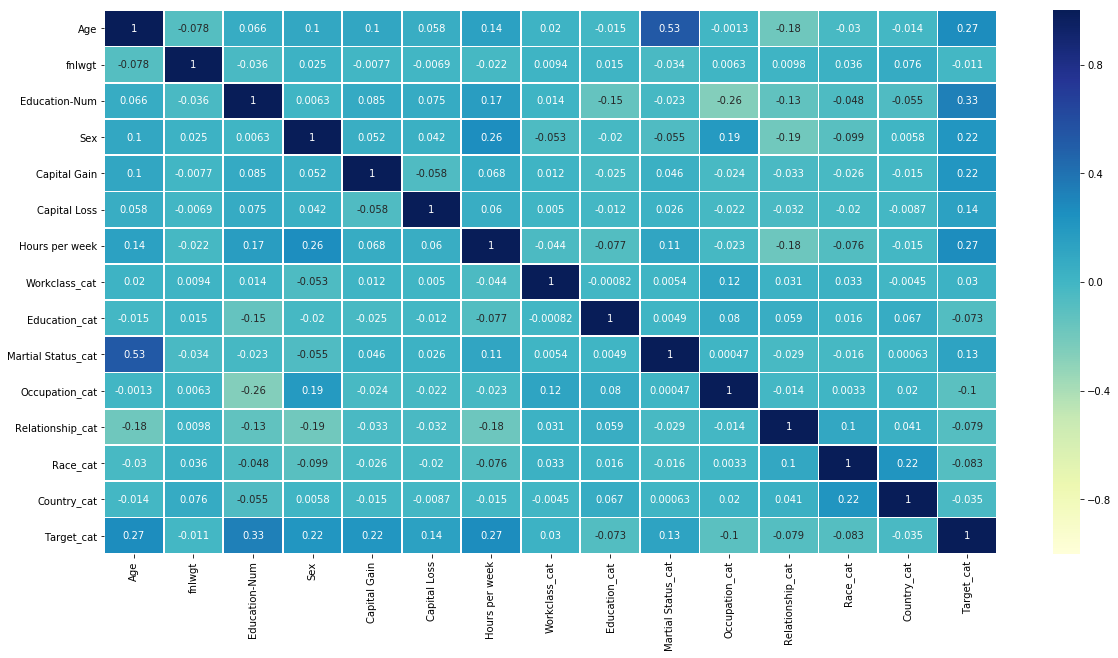

In [10]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train.corr(method='spearman'), vmax=1, vmin=-1, annot=True, linewidths=.8, cmap='YlGnBu');

Checking the correlations with Target_cat:
* As expected Country_cat seem to not have any impact (remeber? the unbalanced one)
* Same with Race_cat and worclass (worclass still to be checked)
* fnlwgt - to be removed
* Education-Num (probably sorted from the lowest to the highest) is better than Education_cat.
* At first glance, it looks like the moste valuable features are: Age, Education_num, Sex (hate it!), Capital Gain and hours per week. Matrial_status & Capital Loss should ont be ignored also.

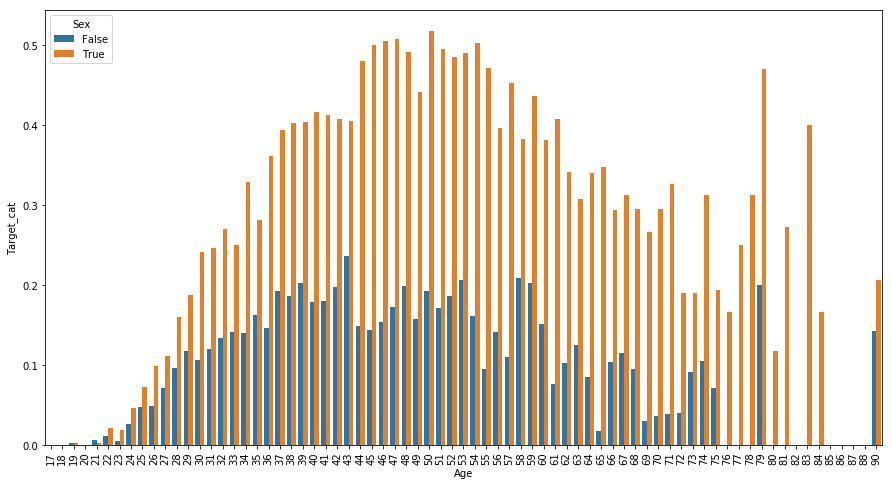

In [11]:
plt.figure(figsize=(15, 8))
sns.barplot(x="Age", y="Target_cat", hue='Sex', data=train, ci=None)
plt.xticks(rotation=90);

* There is a golden age  for higher earnings. Unfortunatelly the sex has a strong impact too. Men between (around) 35 and 60 earns more. We will take this into account in the feature-part.

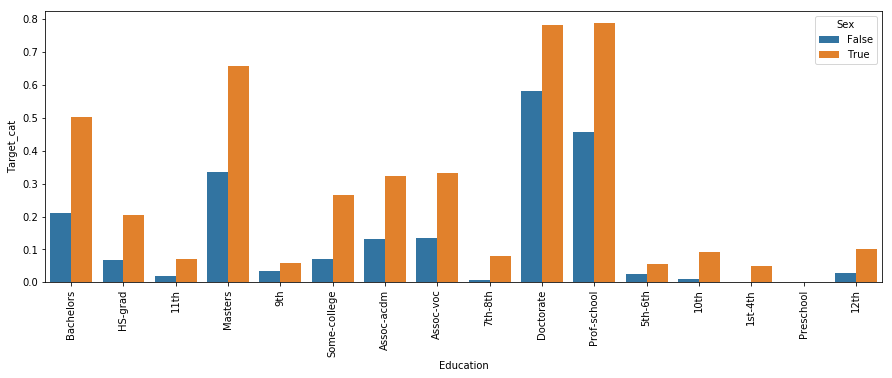

In [12]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Education", y="Target_cat", hue='Sex', data=train, ci=None)
plt.xticks(rotation=90);

* Have you ever asked why you have to go to school ? Doctors, Masters and Prof-schools earns more. 

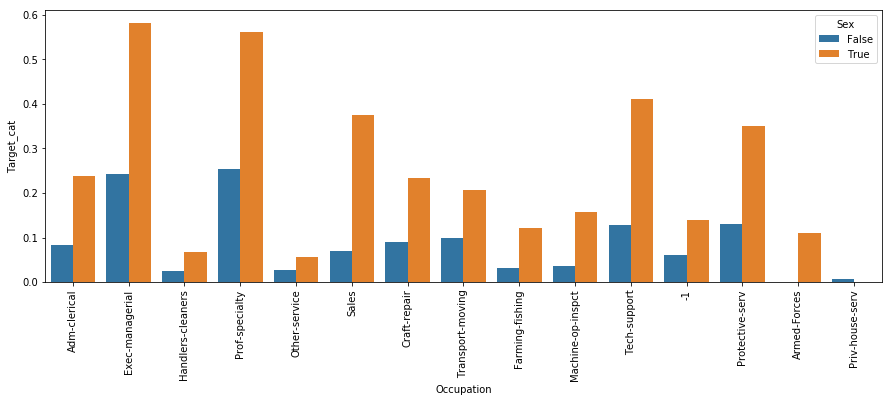

In [13]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Occupation", y="Target_cat", hue='Sex', data=train, ci=None)
plt.xticks(rotation=90);

* From Occupation also some items from the subset of men stand out

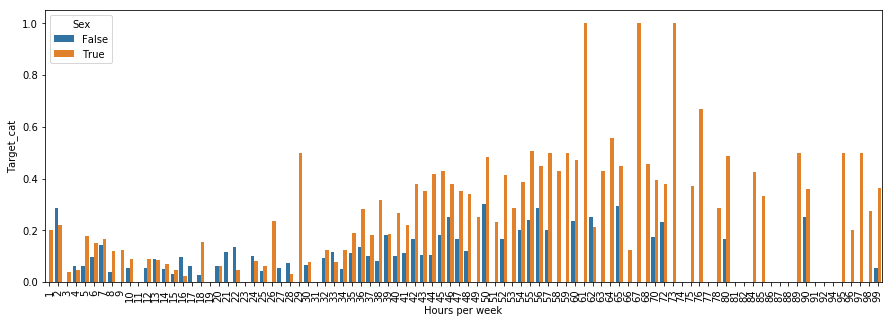

In [14]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Hours per week", y="Target_cat", hue='Sex', data=train, ci=None)
plt.xticks(rotation=90);

* Those who work for the shortest time earn more than 50k, which is not surprising.. But also those working the longest do not earn more than 50k more often than those working between 50 and 75 hours a week. We will try to include it in the features.

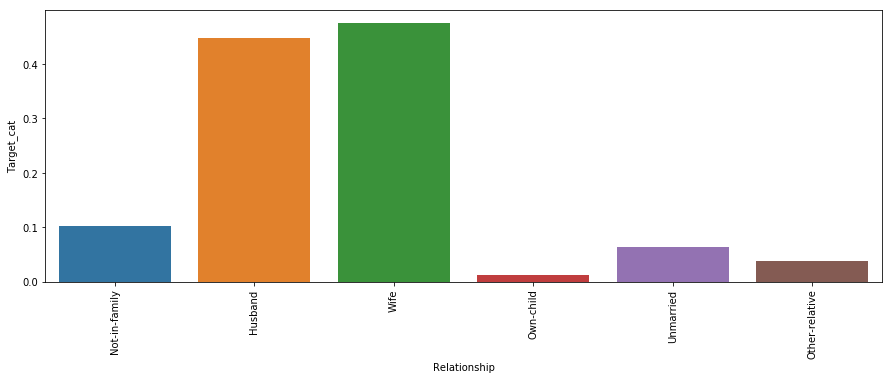

In [15]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Relationship", y="Target_cat", data=train, ci=None)
plt.xticks(rotation=90);

* Husband and wifes more often earns more.

### Features

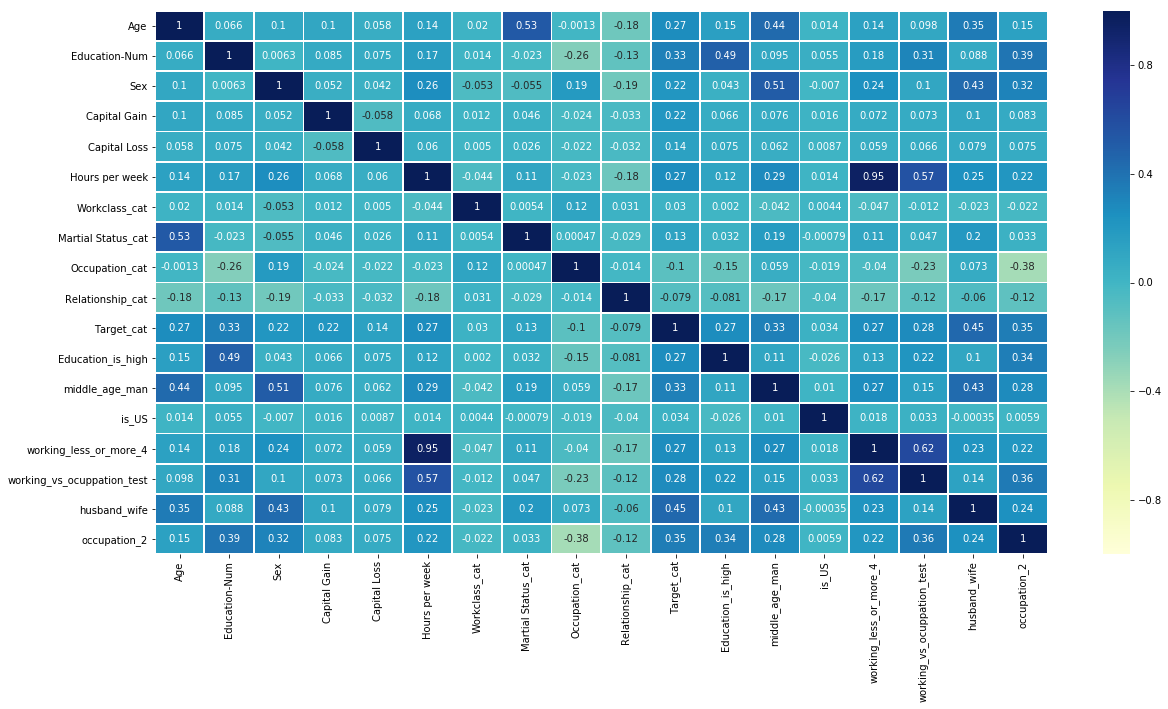

In [16]:
def middle_age_man(row):
    good_age = range(35,60)
    return int(good_age.count(row['Age']) and row['Sex'] == True)

def working_vs_ocuppation(row):
    if (row['working_less_or_more_4'] in [3,4]) and (row['Occupation_cat'] in [0,1,3,5,10]):
        return row['working_less_or_more_4'] + row['Occupation_cat']
    else:
        return 0

def working_more_4(row):
    if row['Hours per week'] < 35:
        more = 0
    elif row['Hours per week'] >=35 and  row['Hours per week'] <= 42:
        more = 1
    elif row['Hours per week'] > 42 and row['Hours per week'] <= 73:
        more = 3 
    elif row['Hours per week'] > 73:
        more = 2
    else:
        more = 'to_check'
    return more

def occupation_2(row): #new
    return int(row['Occupation'] in ['Prof-specialty','Exec-managerial'] and row['Sex'] == True)
        
train['Education_is_high'] = (train.Education.isin(['Masters', 'Doctorate', 'Prof-school']))
train['middle_age_man'] = train.apply(middle_age_man, axis=1)
train['is_US'] = (train.Country.isin(['United-States']))
train['working_less_or_more_4'] = train.apply(working_more_4, axis = 1)
train['working_vs_ocuppation_test'] = train.apply(working_vs_ocuppation, axis = 1)
train['husband_wife'] = train['Relationship'].map(lambda x: int((x =='Husband') | (x == 'Wife') )) #new
train['occupation_2'] = train.apply(occupation_2, axis=1) #new

train.drop('fnlwgt', axis=1, inplace=True) 
train.drop('Education_cat', axis=1, inplace=True) #Education num is better
train.drop('Race_cat', axis=1, inplace=True) #not much impact 
train.drop('Country_cat', axis=1, inplace=True) #replaced by is_us

#Check corr
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train.corr(method='spearman'), vmax=1, vmin=-1, annot=True, linewidths=.8, cmap='YlGnBu');

In [17]:
#train.sample(5)

### Division into train and test data (train_test_split)

In [18]:
features = train.select_dtypes(include=['int8', 'int16', 'int64', 'bool']).columns.values
features = features[features!=['Target_cat']]

X = train[ features ].values
y = train['Target_cat'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2019)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (22792, 17) (22792,)
Test: (9769, 17) (9769,)


In [19]:
features

array(['Age', 'Education-Num', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Workclass_cat', 'Martial Status_cat',
       'Occupation_cat', 'Relationship_cat', 'Education_is_high',
       'middle_age_man', 'is_US', 'working_less_or_more_4',
       'working_vs_ocuppation_test', 'husband_wife', 'occupation_2'],
      dtype=object)

### Model

In [20]:
def train_and_predict_model(X_train, X_test, y_train, y_test, model, success_metric=accuracy_score):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Distribution:")
    print( pd.Series(y_pred).value_counts() )
    
    return success_metric(y_test, y_pred)

#model = DecisionTreeClassifier(max_depth=10, random_state=2019)
model = RandomForestClassifier(max_depth = 9, n_estimators = 40, random_state=2019)

train_and_predict_model(X_train, X_test, y_train, y_test, model)

Distribution:
0    8071
1    1698
dtype: int64


0.8562800696079435

### Feature importances

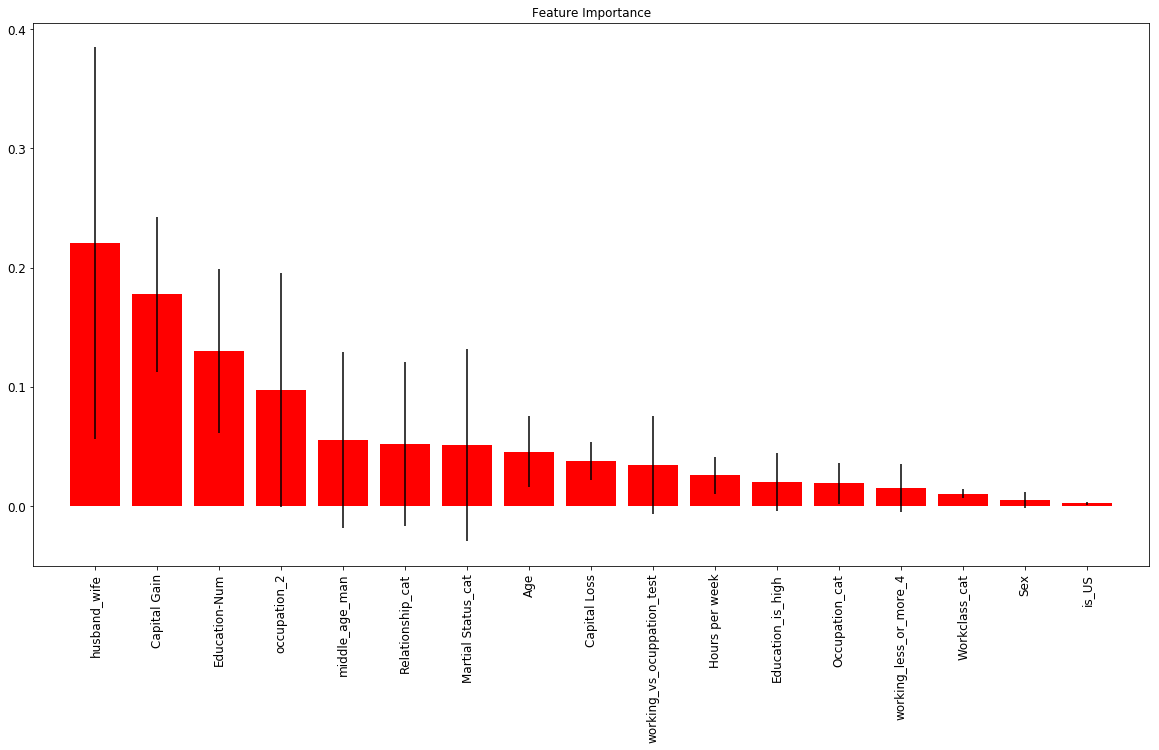

In [21]:
model.fit(X_train, y_train)
skplt.estimators.plot_feature_importances(model, feature_names=features, x_tick_rotation=90, text_fontsize='large' );   

* we could possibly remoove last two features without (or with very little) impact on the model <-- I'll check it later
* the distribution of features does not cause anxiety. Most important attributes are: husband_wife, Capital Gain, occupation_2 and Education-Num, but almost all features seem to have an impact on the result.

### The learning curve

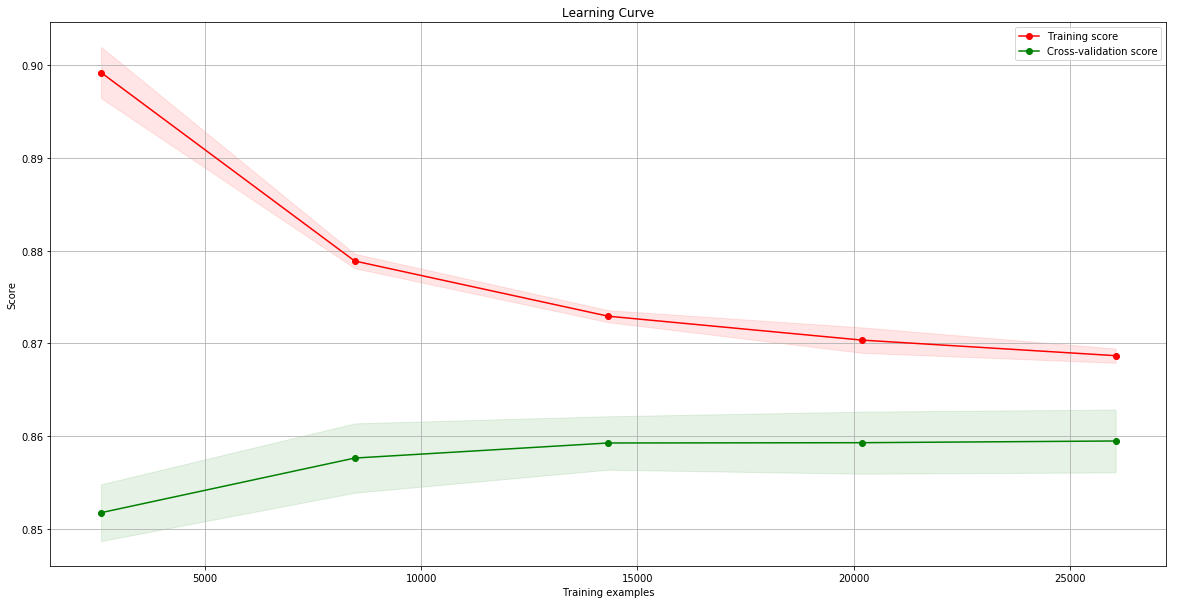

In [22]:
skplt.estimators.plot_learning_curve(model, X, y, cv=5);

* Could be better ;) but it`s OK. The model is not overfitted.

### Final conclusions

A prediction result of 85% accuracy is probably enough to end the project at this point. However, I knew that I have created some features, which took into account whether a person is a man , and I was wondering if the algorithm is better at predicting male income.

It has become a pretext to **look for places where the model is the most mistaken.**

### Analysis of forecasting errors

Making colums: y_pred, y_pred_proba (the probability calculated by the model that a person will earn more than 50k/year), y_test and is_correct (comparision y_test to y_pred).

In [29]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_probas = model.predict_proba(X_test)

In [30]:
df_test = pd.DataFrame(X_test, columns=features)
df_test['y_pred'] = y_pred
df_test['y_pred_proba'] = y_pred_probas[ :, 1 ]
df_test['y_test'] = y_test

df_test['is_correct'] = y_pred == y_test

df_test.head()

,Age,Education-Num,Sex,Capital Gain,Capital Loss,Hours per week,Workclass_cat,Martial Status_cat,Occupation_cat,Relationship_cat,Education_is_high,middle_age_man,is_US,working_less_or_more_4,working_vs_ocuppation_test,husband_wife,occupation_2,y_pred,y_pred_proba,y_test,is_correct
0,24,9,False,0,0,40,5,1,11,2,False,0,False,1,0,1,0,0,0.169077,0,True
1,43,14,False,0,0,30,2,0,4,0,True,0,False,0,0,0,0,0,0.082735,0,True
2,29,10,True,0,0,40,2,1,1,1,False,0,True,1,0,1,1,0,0.326625,0,True
3,26,10,False,0,0,35,2,0,4,0,False,0,True,1,0,0,0,0,0.006575,0,True
4,28,4,True,0,0,40,2,1,6,1,False,0,True,1,0,1,0,0,0.095065,0,True


We can check later, whether manipulating the y_pred_proba level up or down to determine the level of income will improve the quality of the model (by default, the limit value is 0.5).

## Precision vs Recall

ROC curve

In [31]:
precision_score(y_test, y_pred)

0.7667844522968198

In [38]:
y_pred_precision = df_test['y_pred_proba'] > 0.5
'precision:', precision_score(y_test, y_pred_precision), 'recall: ', recall_score(y_test, y_pred_precision)


('precision:', 0.7667844522968198, 'recall: ', 0.5636363636363636)

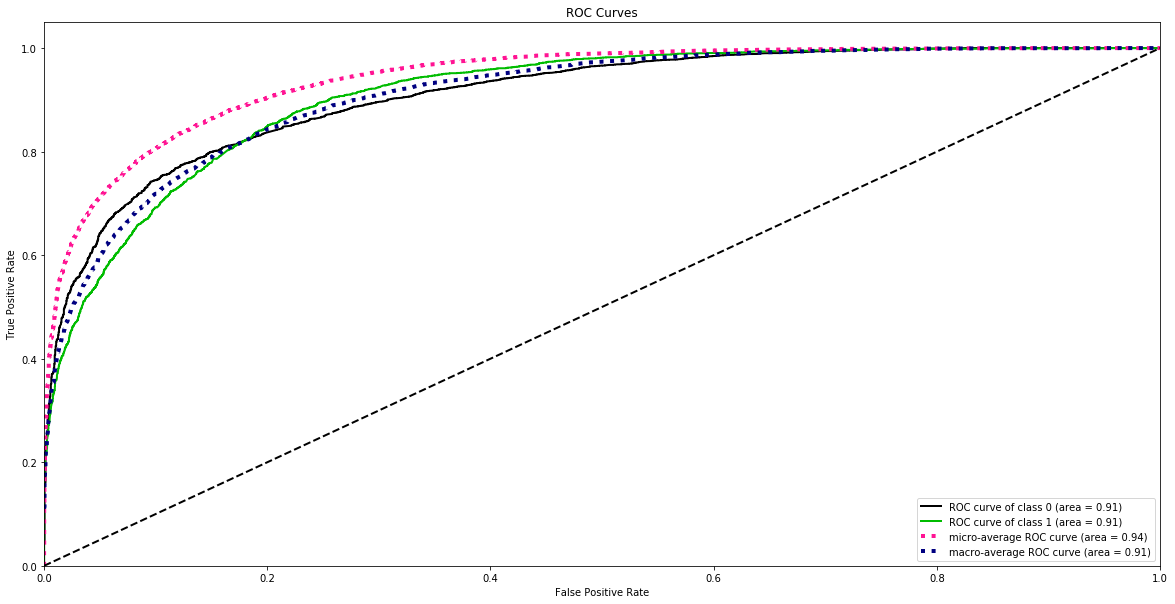

In [33]:
skplt.metrics.plot_roc( y_test, y_pred_probas );

And finally check, whether the model favors men during prediction:

In [34]:
df_test['Sex'].value_counts(normalize=True)

True     0.670795
False    0.329205
Name: Sex, dtype: float64

In [35]:
df_diff = df_test[ df_test.y_test != df_test.y_pred ]
df_diff['Sex'].value_counts(normalize=True)

True     0.837607
False    0.162393
Name: Sex, dtype: float64

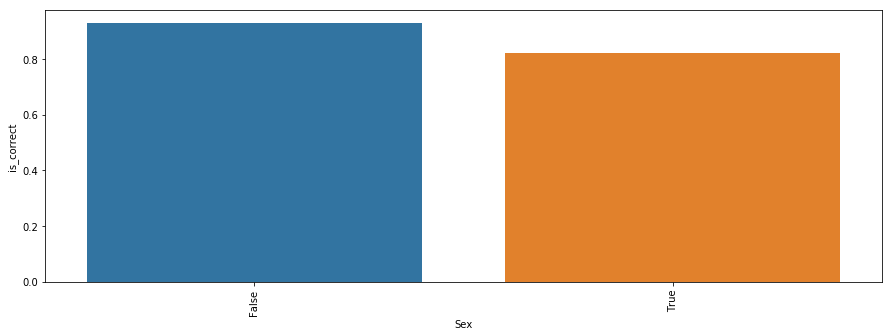

In [36]:
plt.figure(figsize=(15, 5))
sns.barplot(x="Sex", y="is_correct", data=df_test, ci=None)
plt.xticks(rotation=90);

No, I was mistaken. The algoritm better predict famale income ;) !!